In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
omp = 1
mpi = 4

In [4]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt')
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',scheduler='slurm',sbatch_options=['--partition=all12h'])

Initialize a Yambo calculator with scheduler direct


In [5]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 #fs set the width of the FWHM (it correspond to a field width of 42 fs)
scissor = 0.5409 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as
polarization = 'circular'

# RT analysis of the spin dynamics

In this notebook we analyze the dynamics of the spin polarization.

The relevant parameters of the various simulations are organized in a dictionary

In [25]:
simulations = {
    'gamma': {
        'source_dir' : 'NSCF/sampling_gamma.save',
        'run_dir' : 'RT_gamma', 
        'field_int' : 1e3,
        'field_eng' : 1.42,
        'sim_time'  : 2000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [5,10],
        'skip'      : True
    },
    'singlek_high-freq': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'field_int' : 1e3,
        'field_eng' : 1.531,
        'sim_time'  : 10000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True
    },
    'singlek_high-freq_boost': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'field_int' : 1e3,
        'field_eng' : 1.531,
        'sim_time'  : 10000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True,
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [20,'']}
    },
    'k100_random_boost': {
        'source_dir' : 'NSCF/num_k_100-sampling_random_kspan0.05.save',
        'run_dir' : 'RT_k100_random',
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 10000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [5,10],
        'skip'      : True,
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [20,'']}
    }
}

In [26]:
#simulations

### Construction of the SAVE folder and FixSymm procedure

In [27]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=polarization,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for gamma
SAVE folder already present in RT_gamma. No operations performed.
FixSymm folder RT_gamma/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for singlek_high-freq
SAVE folder already present in RT_singlek_high-freq. No operations performed.
FixSymm folder RT_singlek_high-freq/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for singlek_high-freq_boost
SAVE folder already present in RT_singlek_high-freq. No operations performed.
FixSymm folder RT_singlek_high-freq/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for k100_random_boost
SAVE folder already present in RT_k100_random. No operations performed.
FixSymm folder RT_k100_random/FixSymm already found. No operations performed.
 
mv RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek_high-freq/FixSymm/SAVE/ns.kb_

### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations, 
the others are taken from the dictionary.

The input are added to the simulations dict.

In [35]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=polarization,freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=pars['bands'],scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='carriers obs'  # do not write ndb.carriers and ndb.RT_observables on disk
    rt_input['arguments'].append('DephCVonly') # enable the dephasing only for cv transitions
    rt_input['variables']['IOtime'] = [[1.0,5.0,1.0],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    if pars.get('boost') is not None:
        rt_input['variables'].update(pars['boost'])
    pars['input'] = rt_input

In [37]:
#simulations['k100_random_boost']

In [16]:
study = D.Dataset(num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 1 parallel tasks


In [17]:
for id,sim in simulations.items():
    study.append_run(id=id,input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [18]:
#study.runs[1]

In [19]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0], [1], [2], [3]] 

Run the task [0] 
Skip the run of gamma
Task [0] ended 

Run the task [1] 
Skip the run of singlek_high-freq
Task [1] ended 

Run the task [2] 
Skip the run of singlek_high-freq_boost
Task [2] ended 

Run the task [3] 
Skip the run of k100_random_boost
Task [3] ended 



In [20]:
results[1].data.keys()

dict_keys(['spin_magnetization', 'carriers', 'polarization', 'current', 'external_field', 'orbt_magnetization'])

In [21]:
results[1].data['carriers']['dne']

array([0.0000000e+00, 1.2900469e-10, 5.2885019e-10, ..., 7.3014344e-03,
       7.3014344e-03, 7.3014344e-03])

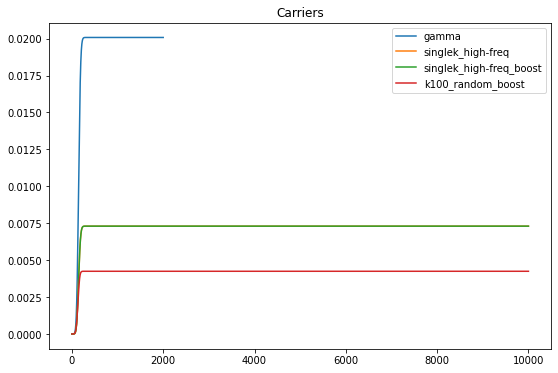

In [22]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()
    #plt.show()

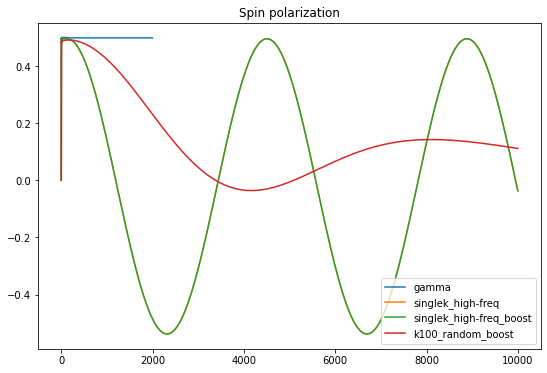

In [23]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['spin_magnetization']['time']
    pz = r.data['spin_magnetization']['Mc_z']
    plt.plot(t,pz,label=D.name_from_id(study.ids[ind]))
    plt.title('Spin polarization')
    plt.legend()
    #plt.show()

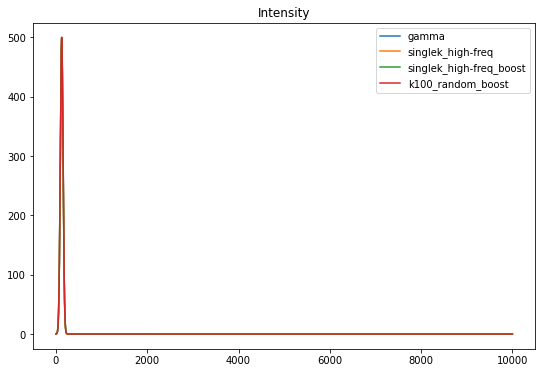

In [24]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['external_field']['time']
    Int = r.data['external_field']['Intensity']
    plt.plot(t,Int,label=D.name_from_id(study.ids[ind]))
    plt.title('Intensity')
    plt.legend()
    #plt.ylim(-0.1,2)
    #plt.show()

### Analysis for the THz pulse

We compute amplitude of the THz pulse that realizes the $\pi$ condition (on a specific k points for
singlek_high_fre case)

In [54]:
dipoles = P.YamboDipolesParser('RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/ndb.dipoles')
dft = P.YamboDftParser('RT_singlek_high-freq/FixSymm/SAVE/ns.db1')

Parse file : RT_singlek_high-freq/FixSymm/singlek_high-freq_boost/ndb.dipoles
Parse file : RT_singlek_high-freq/FixSymm/SAVE/ns.db1


There are 48 kpoints in this case. The ccp transition energies for all these points is

In [67]:
de_ccp = 1e3*dft.get_transitions(initial=[8,9],final=[8,9],set_scissor=scissor)[0][0]
de_ccp # meV

0.9444647438892062

Instead the dipoles for the various kpoints are not equal and the arrays sums to zero if all the points
are included (this happens also for the cv transition, check why!).

In this test case we choose one k point

In [74]:
dip = dipoles.get_r_dipole(k,2,3,0)
dip

array([-15.27632267,  22.9487412 ])

We set the FWH of the THz pulse

In [126]:
fwhm =  20 #ps

In [127]:
N = int(2e5)
time = np.linspace(0,200,N) # in ps
time[1]-time[0]

0.0010000050000250002

In [128]:
pulse = U.gaussianPulse(time,energy=de_ccp,fwhm=fwhm,THz_pulse=True,t_start=0)

time unit: ps - energy unit: meV
period of the oscillations 4.378848150754763 ps^-1
width of the pulse 8.493218002880191 ps
fwhm of the pulse 20 ps


In [133]:
width = 8.493 #ps

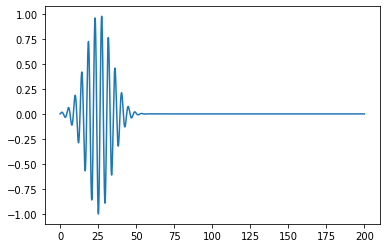

In [134]:
plt.plot(time,pulse)

In [135]:
energies,ft = U.evalPulseFourierTransform(time,pulse,THz_pulse=True)

time unit: ps - energy unit: meV
energy resolution of the FT: 0.020678235088307597 meV
maximum energy: 2067.8028305956714 meV
FWHM of the FT of the pulse: 0.1654258807064608 meV


(0.5, 1.5)

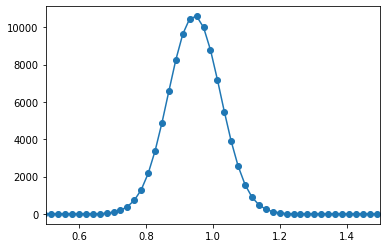

In [136]:
plt.plot(energies,ft)
plt.scatter(energies,ft)
plt.xlim(0.5,1.5)

We compute the intensity of the pulse that realizes the $\pi$ condition

In [137]:
pars = U.pulseParsFromTheta(dip,np.pi,width*1e3)
pars

coupling frequency (fs^-1): 0.00014757025047868838
field intensity (kW/cm^2) : 1.1767294150187788


(0.00014757025047868838, 1.1767294150187788)

In [138]:
U.pulseParsFromIntensity(dip,pars[1],width*1e3)

coupling frequency (fs^-1): 0.00014757025047868835
pulse area : 3.1415926535897927


(0.00014757025047868835, 3.1415926535897927)

## Simulations with the THz pulse

Open questions:
* polarization of the THz pulse? Actually linear is chosen
* why the maximum intensity for the  circular polarization is one half of the
  nominal value?

In [38]:
de_ccp = 0.944465 #meV
int_THz = 1.17673 #kW/cm^2
fwhm = 20 #ps
T_delay = 1 #ps

In [40]:
simulations = {
    'echo_THz_pi_noboost': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'fields'  : [dict(index=1,int=1000,freq=1.531,width=100,polarization='circular'),
                     dict(index=2,int=int_THz,freq=de_ccp,freq_units='meV',width=fwhm,width_units='ps',tstart=T_delay,tstart_units='ps')],
        'sim_time'  : 80*1e3,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True
    },
    'echo_THz_pi': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'fields'  : [dict(index=1,int=1000,freq=1.531,width=100,polarization='circular'),
                     dict(index=2,int=int_THz,freq=de_ccp,freq_units='meV',width=fwhm,width_units='ps',tstart=T_delay,tstart_units='ps')],
        'sim_time'  : 80*1e3,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True,
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [10,'']}
    },
    'echo_THz_pi_circular': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'fields'  : [dict(index=1,int=1000,freq=1.531,width=100,polarization='circular'),
                     dict(index=2,int=int_THz,freq=de_ccp,freq_units='meV',width=fwhm,
                          width_units='ps',polarization='circular',tstart=T_delay,tstart_units='ps')],
        'sim_time'  : 80*1e3,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True,
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [10,'']}
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [41]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=polarization,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for echo_THz_pi_noboost
SAVE folder already present in RT_singlek_high-freq. No operations performed.
FixSymm folder RT_singlek_high-freq/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for echo_THz_pi
SAVE folder already present in RT_singlek_high-freq. No operations performed.
FixSymm folder RT_singlek_high-freq/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for echo_THz_pi_circular
SAVE folder already present in RT_singlek_high-freq. No operations performed.
FixSymm folder RT_singlek_high-freq/FixSymm already found. No operations performed.
 
mv RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf_hide


In [42]:
#simulations

### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations, 
the others are taken from the dictionary.

The input are added to the simulations dict.

In [43]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p2 -v ip -V rt',folder=pars['rt_run_dir'])
    for f in pars['fields']:
        rt_input.set_rt_field(**f)
    rt_input.set_rt_bands(bands=pars['bands'],scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='carriers obs'  # do not write ndb.carriers and ndb.RT_observables on disk
    rt_input['arguments'].append('DephCVonly') # enable the dephasing only for cv transitions
    rt_input['variables']['IOtime'] = [[1.0,5.0,1.0],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    if pars.get('boost') is not None:
        rt_input['variables'].update(pars['boost'])
    pars['input'] = rt_input

In [45]:
#simulations['echo_THz_pi_circular']['input']

In [46]:
study = D.Dataset(num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 1 parallel tasks


In [47]:
for id,sim in simulations.items():
    study.append_run(id=id,input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [48]:
#study.runs[1]

In [49]:
results = study.run()

Run the selection [0, 1, 2] with the parallel task_groups [[0], [1], [2]] 

Run the task [0] 
Skip the run of echo_THz_pi_noboost
Task [0] ended 

Run the task [1] 
Skip the run of echo_THz_pi
Task [1] ended 

Run the task [2] 
run command: cd RT_singlek_high-freq/FixSymm; mpirun -np 4 yambo_rt -F echo_THz_pi_circular.in -J echo_THz_pi_circular -C echo_THz_pi_circular
computation echo_THz_pi_circular is running...
computation echo_THz_pi_circular ended
Task [2] ended 



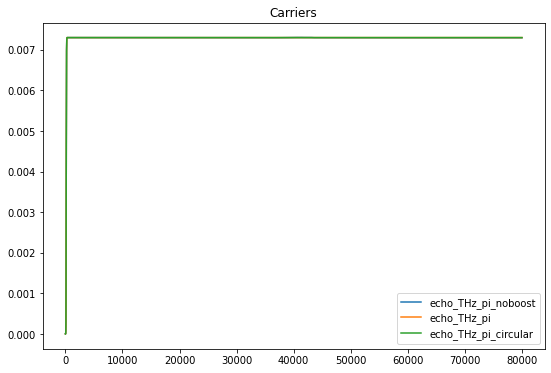

In [50]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()
    #plt.show()

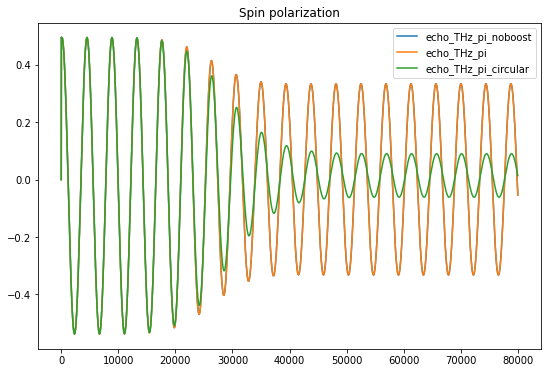

In [51]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['spin_magnetization']['time']
    pz = r.data['spin_magnetization']['Mc_z']
    plt.plot(t,pz,label=D.name_from_id(study.ids[ind]))
    plt.title('Spin polarization')
    plt.legend()
    #plt.show()

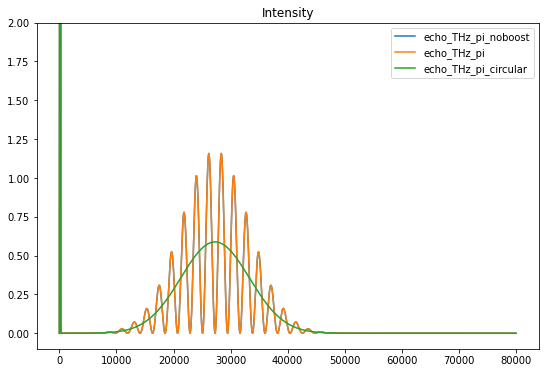

In [52]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['external_field']['time']
    Int = r.data['external_field']['Intensity']
    plt.plot(t,Int,label=D.name_from_id(study.ids[ind]))
    plt.title('Intensity')
    plt.legend()
    plt.ylim(-0.1,2)
    #plt.show()

### Analysis of the $G_<$ in function of time

We perform some calculations storing the $G_<$ on file. In this way we can study the
dynamics of the density matrix itself.

In [7]:
simulations = {
    'singlek_high-freq_Glesser': {
        'source_dir' : 'NSCF/sampling_1k-maxfreq.save',
        'run_dir' : 'RT_singlek_high-freq',
        'field_int' : 1e3,
        'field_eng' : 1.531,
        'sim_time'  : 10000,
        'eta'       : 2e-3,
        'no_sym'    : False,
        'bands'     : [7,10],
        'skip'      : True,
        'boost'     : {'dTupdateTimeSet' : [500,'fs'], 'dT_SET' : [20,'']}
    }
}

In [8]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=polarization,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE and perform FixSymm for singlek_high-freq_Glesser
SAVE folder already present in RT_singlek_high-freq. No operations performed.
FixSymm folder RT_singlek_high-freq/FixSymm already found. No operations performed.
 
mv RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek_high-freq/FixSymm/SAVE/ns.kb_pp_pwscf_hide


In [9]:
for pars in simulations.values():
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=polarization,freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=pars['bands'],scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='carriers obs'  # do not write ndb.carriers and ndb.RT_observables on disk
    rt_input['arguments'].append('DephCVonly') # enable the dephasing only for cv transitions
    rt_input['arguments'].append('SaveGhistory') # save G_lesser in function of the time
    rt_input['variables']['IOtime'] = [[1.0,10.0,1.0],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    if pars.get('boost') is not None:
        rt_input['variables'].update(pars['boost'])
    pars['input'] = rt_input

In [10]:
#simulations

In [11]:
study = D.Dataset(num_tasks=1)
study.set_postprocessing_function(D.PostProcessing.yambo_parse_data)

Initialize a Dataset with 1 parallel tasks


In [12]:
for id,sim in simulations.items():
    study.append_run(id=id,input=sim['input'],run_dir=sim['rt_run_dir'],runner=code,skip=sim['skip'])

In [13]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of singlek_high-freq_Glesser
Task [0] ended 



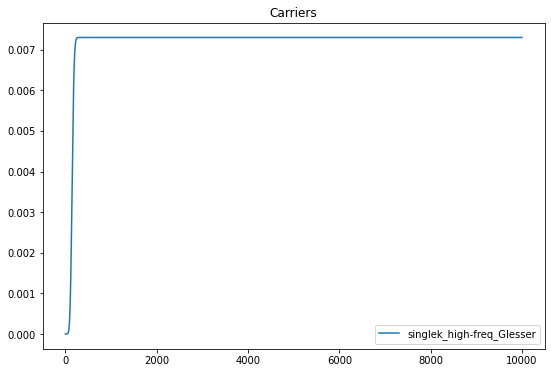

In [37]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['carriers']['time']
    dne = r.data['carriers']['dne']
    plt.plot(t,dne,label=D.name_from_id(study.ids[ind]))
    plt.title('Carriers')
    plt.legend()
    #plt.show()

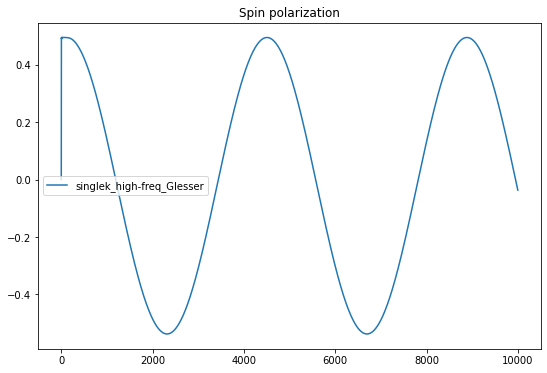

In [38]:
plt.figure(figsize=(9,6))
for ind,r in results.items():
    t = r.data['spin_magnetization']['time']
    pz = r.data['spin_magnetization']['Mc_z']
    plt.plot(t,pz,label=D.name_from_id(study.ids[ind]))
    plt.title('Spin polarization')
    plt.legend()
    #plt.show()

### Observables can be computed directly from the $G_<$

In [362]:
Gfile = 'RT_singlek_high-freq/FixSymm/singlek_high-freq_Glesser/ndb.RT_G_PAR'

In [363]:
dg = U.get_variable_from_db(Gfile,'dG_lesser')

In [364]:
dg.shape

(2003, 48, 4, 4, 2)

In [365]:
ntimes = len(dg)
nk = len(dg[0])

In [366]:
tmax = 1e4
tstep = tmax/(ntimes-1)
time = np.array([tstep*ind for ind in range(ntimes)])
time.shape

(2003,)

In [367]:
# define the density matrix in the conduction sector as -i*G_<
DM = - 1j*dg[:,:,2:,2:,0] + dg[:,:,2:,2:,1]

We can compute the number of carriers in function of time

In [368]:
traces = np.zeros([ntimes,nk],dtype=complex)
for t in range(ntimes):
    for k in range(nk):
        traces[t][k] = np.trace(DM[t][k])

In [369]:
carriers = np.zeros([ntimes],dtype=complex)
for t in range(ntimes):
    carriers[t] = np.average(traces[t])

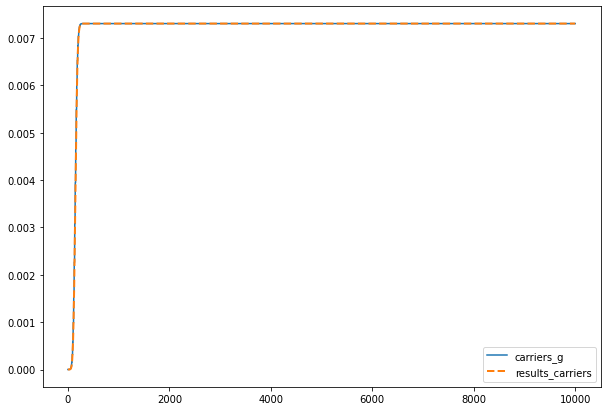

In [370]:
plt.figure(figsize=(10,7))
plt.plot(time,carriers.real,label='carriers_g')
results_time = r.data['carriers']['time']
dne = r.data['carriers']['dne']
plt.plot(results_time,dne,label='results_carriers',linestyle='--',linewidth=2)
plt.legend()

We also compute the spin polarization in function of time

In [371]:
dipoles = results[0].dipoles
dip_spin = dipoles.dip_spin
dip_spin.shape

(48, 4, 4, 3, 2)

In [372]:
Sz = dip_spin[:,2:,2:,2,0] + 1j*dip_spin[:,2:,2:,2,1]
Sz.shape

(48, 2, 2)

In [373]:
k = 5
Sz[k]

array([[-0.68482554+0.j        ,  0.72465445+0.01365421j],
       [ 0.72465445-0.01365421j,  0.68494146+0.j        ]])

In [374]:
pzs = np.zeros([ntimes,nk],dtype=complex)
for t in range(ntimes):
    for k in range(nk):
        tt = traces[t,k]
        if t == 0:
            pzs[t][k] = 0.
        else:
            pzs[t][k] = np.trace(np.matmul(DM[t][k],Sz[k].T))/tt

In [375]:
pz = np.zeros([ntimes],dtype=complex)
for t in range(ntimes):
    pz[t] = np.average(pzs[t])

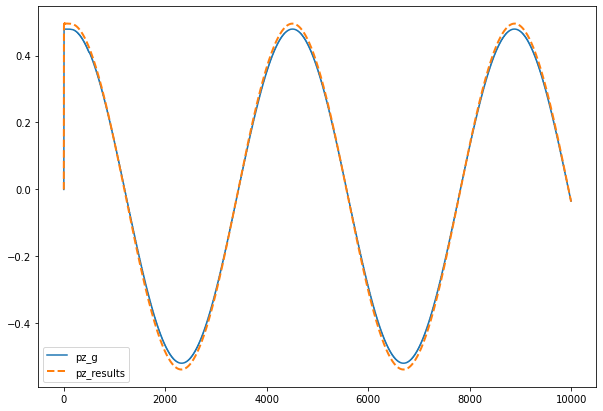

In [376]:
plt.figure(figsize=(10,7))
plt.plot(time,pz.real,label='pz_g')
results_time = r.data['spin_magnetization']['time']
results_pz = r.data['spin_magnetization']['Mc_z']
plt.plot(results_time,results_pz,label='pz_results',linestyle='--',linewidth=2)
plt.legend()

### Construction of the Bloch vectors from the density matrix

In [417]:
DM.shape

(2003, 48, 2, 2)

In [449]:
u1 = 2*DM[:,:,0,1].real
u2 = -2*DM[:,:,0,1].imag
u3 = (DM[:,:,0,0]-DM[:,:,1,1]).real #just to avoid warnings

Since the trace of the DM in the conduction sector is not qual to one we rescale the Bloch vectors

In [495]:
Bloch = np.array([u1,u2,u3])
for t in range(ntimes):
    for k in range(nk):
        tt = traces[t,k].real
        if tt == 0:
            Bloch[:,t,k] = 0.
        else:
            Bloch[:,t,k] = Bloch[:,t,k]/tt
Bloch.shape

(3, 2003, 48)

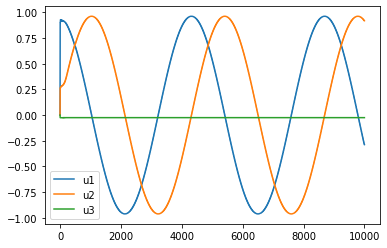

In [496]:
k = 0
plt.plot(time,Bloch[0,:,k],label='u1')
plt.plot(time,Bloch[1,:,k],label='u2')
plt.plot(time,Bloch[2,:,k],label='u3')
#plt.xlim(0,2000)
plt.legend()

And we can express the expectation values in terms of the Bloch vector

In [497]:
Sz[9]

array([[ 0.02317222+0.j        ,  0.04147356-0.99695318j],
       [ 0.04147356+0.99695318j, -0.02317717+0.j        ]])

In [501]:
pzs_bloch = np.zeros([ntimes,nk],dtype=complex)
for k in range(nk):
    A = Sz[k,0,0]
    B = Sz[k,0,1].real
    C = Sz[k,0,1].imag
    pzs_bloch[:,k] = A*Bloch[2,:,k]+B*Bloch[0,:,k]+C*Bloch[1,:,k] 
    #for t in range(ntimes):
    #    pzs_bloch[t,k] = A*Bloch[2,t,k]+B*Bloch[0,t,k]+C*Bloch[1,t,k] 

In [502]:
pz_bloch = np.zeros([ntimes])
for t in range(ntimes):
    pz_bloch[t] = np.average(pzs_bloch[t,:].real)

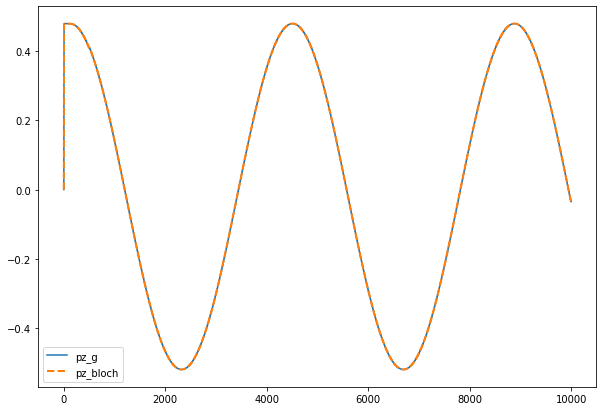

In [503]:
plt.figure(figsize=(10,7))
plt.plot(time,pz.real,label='pz_g')
plt.plot(time,pz_bloch,label='pz_bloch',linestyle='--',linewidth=2)
plt.legend()

## TLS analysis

Now we reproduce these results using the equation for a TLS .

We choose the value of the Bloch vector at t=500 fs as the starting point for the TLS analysis.

Note that we are using _rescaled_ Bloch vectors as the starting point for the TLS analysis.

In [504]:
ind_0 = 100
t0 = time[ind_0]
t0

499.5004995004995

In [521]:
Bloch0 = np.zeros([3,nk])
Bloch0[:,:] = Bloch[:,ind_0,:]
Bloch0.shape

(3, 48)

In [522]:
from scipy.integrate import odeint

In [523]:
def Bloch_Eq(u, t, delta, Omega_r):
    dudt = [delta*u[1], -delta*u[0]+Omega_r(t)*u[2],-Omega_r(t)*u[1]]
    return dudt

In [524]:
# we choose no pump in the THz
Omega_r = lambda t : 0.

In [525]:
Bloch_tls = np.zeros([3,ntimes,nk])
Bloch_tls.shape

(3, 2003, 48)

In [526]:
for k in range(nk):
    sol = odeint(Bloch_Eq, Bloch0[:,k], time, args=(delta_psm1, Omega_r))
    Bloch_tls[:,:,k] = sol.T

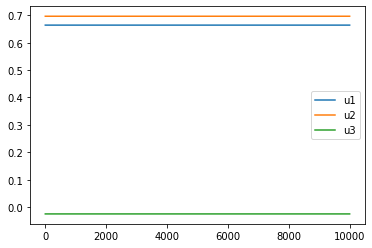

In [527]:
k = 0
plt.plot(time,Bloch_tls[0,:,k],label='u1')
plt.plot(time,Bloch_tls[1,:,k],label='u2')
plt.plot(time,Bloch_tls[2,:,k],label='u3')
plt.legend(loc='best')

We rotate the Bloch vector in the original frame

In [528]:
e_pump = 0.9444464 #meV
omega = e_pump/(U.Planck_reduced_ev_ps*1e6)

In [529]:
Bloch_tls_of = np.zeros([3,ntimes,nk])
for k in range(nk):
    Bloch_tls_of[0,:,k] = np.cos(omega*time)*Bloch_tls[0,:,k] - np.sin(omega*time)*Bloch_tls[1,:,k]
    Bloch_tls_of[1,:,k] = np.sin(omega*time)*Bloch_tls[0,:,k] + np.cos(omega*time)*Bloch_tls[1,:,k]
    Bloch_tls_of[2,:,k] = Bloch_tls[2,:,k]

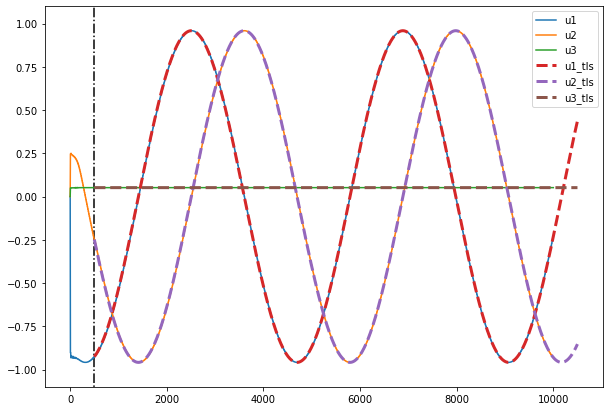

In [535]:
k = 24
fig, ax = plt.subplots(figsize=(10, 7))

plt.plot(time,Bloch[0,:,k],label='u1')
plt.plot(time,Bloch[1,:,k],label='u2')
plt.plot(time,Bloch[2,:,k],label='u3')

plt.plot(t0+time,Bloch_tls_of[0,:,k],label='u1_tls',linestyle='--',linewidth=3)
plt.plot(t0+time,Bloch_tls_of[1,:,k],label='u2_tls',linestyle='--',linewidth=3)
plt.plot(t0+time,Bloch_tls_of[2,:,k],label='u3_tls',linestyle='--',linewidth=3)

plt.vlines(t0,-2,2,color='black',linestyles='-.')
plt.ylim(-1.1,1.1)
plt.legend(loc='best')

Once that we have the Bloch vector we can compute the expectation value of the spin polarization

In [532]:
pzs_tls = np.zeros([ntimes,nk],dtype=complex)
for k in range(nk):
    A = Sz[k,0,0]
    B = Sz[k,0,1].real
    C = Sz[k,0,1].imag
    pzs_tls[:,k] = (A*Bloch_tls_of[2,:,k]+B*Bloch_tls_of[0,:,k]+C*Bloch_tls_of[1,:,k]) 

In [533]:
pz_tls = np.zeros([ntimes])
for t in range(ntimes):
    pz_tls[t] = np.average(pzs_tls[t,:].real)

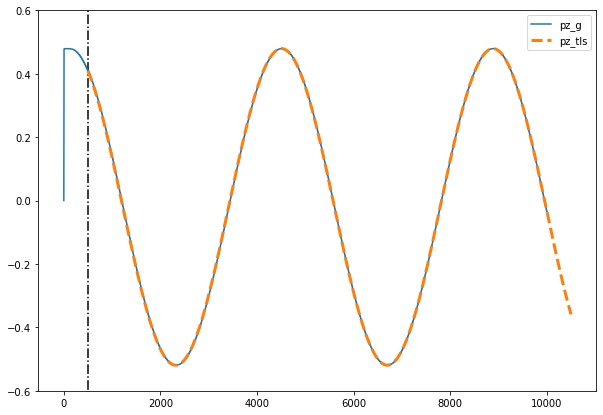

In [539]:
plt.figure(figsize=(10,7))
plt.plot(time,pz.real,label='pz_g')
plt.plot(t0+time,pz_tls,label='pz_tls',linestyle='--',linewidth=3)
plt.vlines(t0,-2,2,color='black',linestyles='-.')
plt.ylim(-0.6,0.6)
plt.legend()

## TLS with the THz pulse

Now that the procedure is clarified we can use the TLS to reproduce the RT results with a THz pulse

In [542]:
coupl_freq = 0.14756 # ps^-1
e_pump = 0.9444464 # meV
fwhm =  20 #ps

In [561]:
T = 80 # ps - lenght of the simulation
dt = 0.1 # ps - resolution of time sampling
N = int(T/dt) # number of sampled points
time = np.linspace(0,T,N+1)

In [586]:
pulse = U.gaussianPulse(time,energy=e_pump,amplitude=coupl_freq,fwhm=fwhm,THz_pulse=True,t_start=0.5)

time unit: ps - energy unit: meV
period of the oscillations 4.3789332006901835 ps
width of the pulse 8.493218002880191 ps
fwhm of the pulse 20 ps


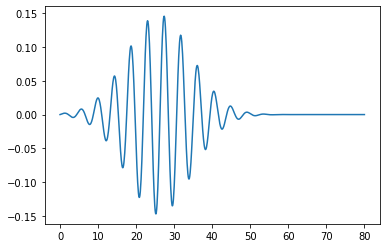

In [587]:
plt.plot(time,pulse)

In [588]:
Omega_r = lambda t: U.gaussianPulse(t,energy=e_pump,amplitude=coupl_freq,fwhm=fwhm,
                    THz_pulse=True,t_start=0.5,envelope_only=True,verbose=False)

In [589]:
Bloch_tls = np.zeros([3,len(time),nk])
Bloch_tls.shape

(3, 801, 48)

In [590]:
for k in range(nk):
    sol = odeint(Bloch_Eq, Bloch0[:,k], time, args=(delta_psm1, Omega_r))
    Bloch_tls[:,:,k] = sol.T

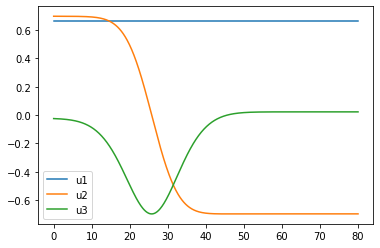

In [591]:
k = 0
plt.plot(time,Bloch_tls[0,:,k],label='u1')
plt.plot(time,Bloch_tls[1,:,k],label='u2')
plt.plot(time,Bloch_tls[2,:,k],label='u3')
plt.legend(loc='best')

We rotate the Bloch vector in the original frame

In [592]:
omega = e_pump/(U.Planck_reduced_ev_ps*1e3)

In [593]:
Bloch_tls_of = np.zeros([3,len(time),nk])
for k in range(nk):
    Bloch_tls_of[0,:,k] = np.cos(omega*time)*Bloch_tls[0,:,k] - np.sin(omega*time)*Bloch_tls[1,:,k]
    Bloch_tls_of[1,:,k] = np.sin(omega*time)*Bloch_tls[0,:,k] + np.cos(omega*time)*Bloch_tls[1,:,k]
    Bloch_tls_of[2,:,k] = Bloch_tls[2,:,k]

Once that we have the Bloch vector we can compute the expectation value of the spin polarization

In [594]:
pzs_tls = np.zeros([len(time),nk],dtype=complex)
for k in range(nk):
    A = Sz[k,0,0]
    B = Sz[k,0,1].real
    C = Sz[k,0,1].imag
    pzs_tls[:,k] = (A*Bloch_tls_of[2,:,k]+B*Bloch_tls_of[0,:,k]+C*Bloch_tls_of[1,:,k]) 

In [595]:
pz_tls = np.zeros([len(time)])
for t in range(len(time)):
    pz_tls[t] = np.average(pzs_tls[t,:].real)

In [596]:
res = P.YamboOutputParser(['RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.spin_magnetization'])

In [597]:
res_t = res['spin_magnetization']['time']
res_pz = res['spin_magnetization']['Mc_z']

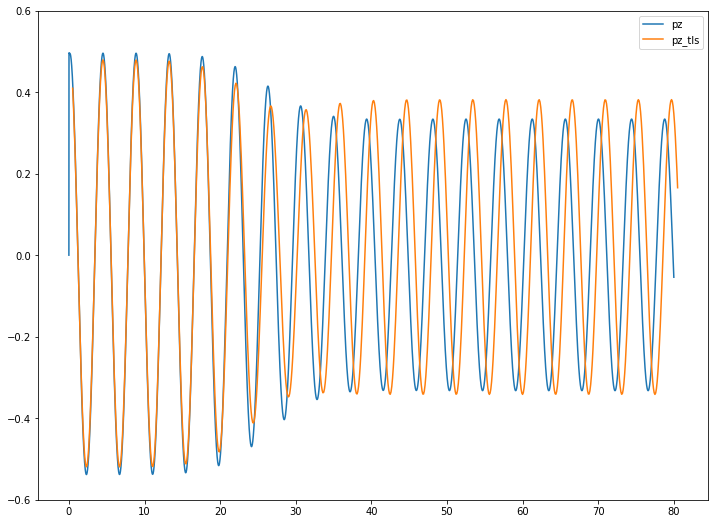

In [601]:
plt.figure(figsize=(12,9))
#plt.plot(time,pz.real,label='pz_g')
plt.plot(1e-3*res_t,res_pz,label='pz')
plt.plot(0.5+time,pz_tls,label='pz_tls')
#plt.vlines(t0,-2,2,color='black',linestyles='-.')
plt.ylim(-0.6,0.6)
plt.legend()

check the possible origin(s) of the small deviations. Some possibilities:
* in Yambo a single pulse intensity produces different coupling frequencies at each k since the
  k dependent dipoles are considered when the interaction hamiltonian is built. In the TLS this procedure
  has to be implemented